# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

2023-01-24 10:59:53.954664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.10.0'

#### Load Image Data

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# DATA_LIST = os.listdir('/content/gdrive/My Drive/Colab Notebooks/all/train')
# DATASET_PATH  = '/content/gdrive/My Drive/Colab Notebooks/all/train'
# TEST_DIR =  '/content/gdrive/My Drive/Colab Notebooks/all/test'
DATA_LIST = os.listdir('../Data/Covid_Data_GradientCrescent/all/train')
DATASET_PATH  = '../Data/Covid_Data_GradientCrescent/all/train'
TEST_DIR =  '../Data/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.00001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   channel_shift_range = 20,
                                   validation_split = 0.2,fill_mode='constant')



train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


In [28]:
np.argwhere(train_batches[0][1][0]==1).item()

3

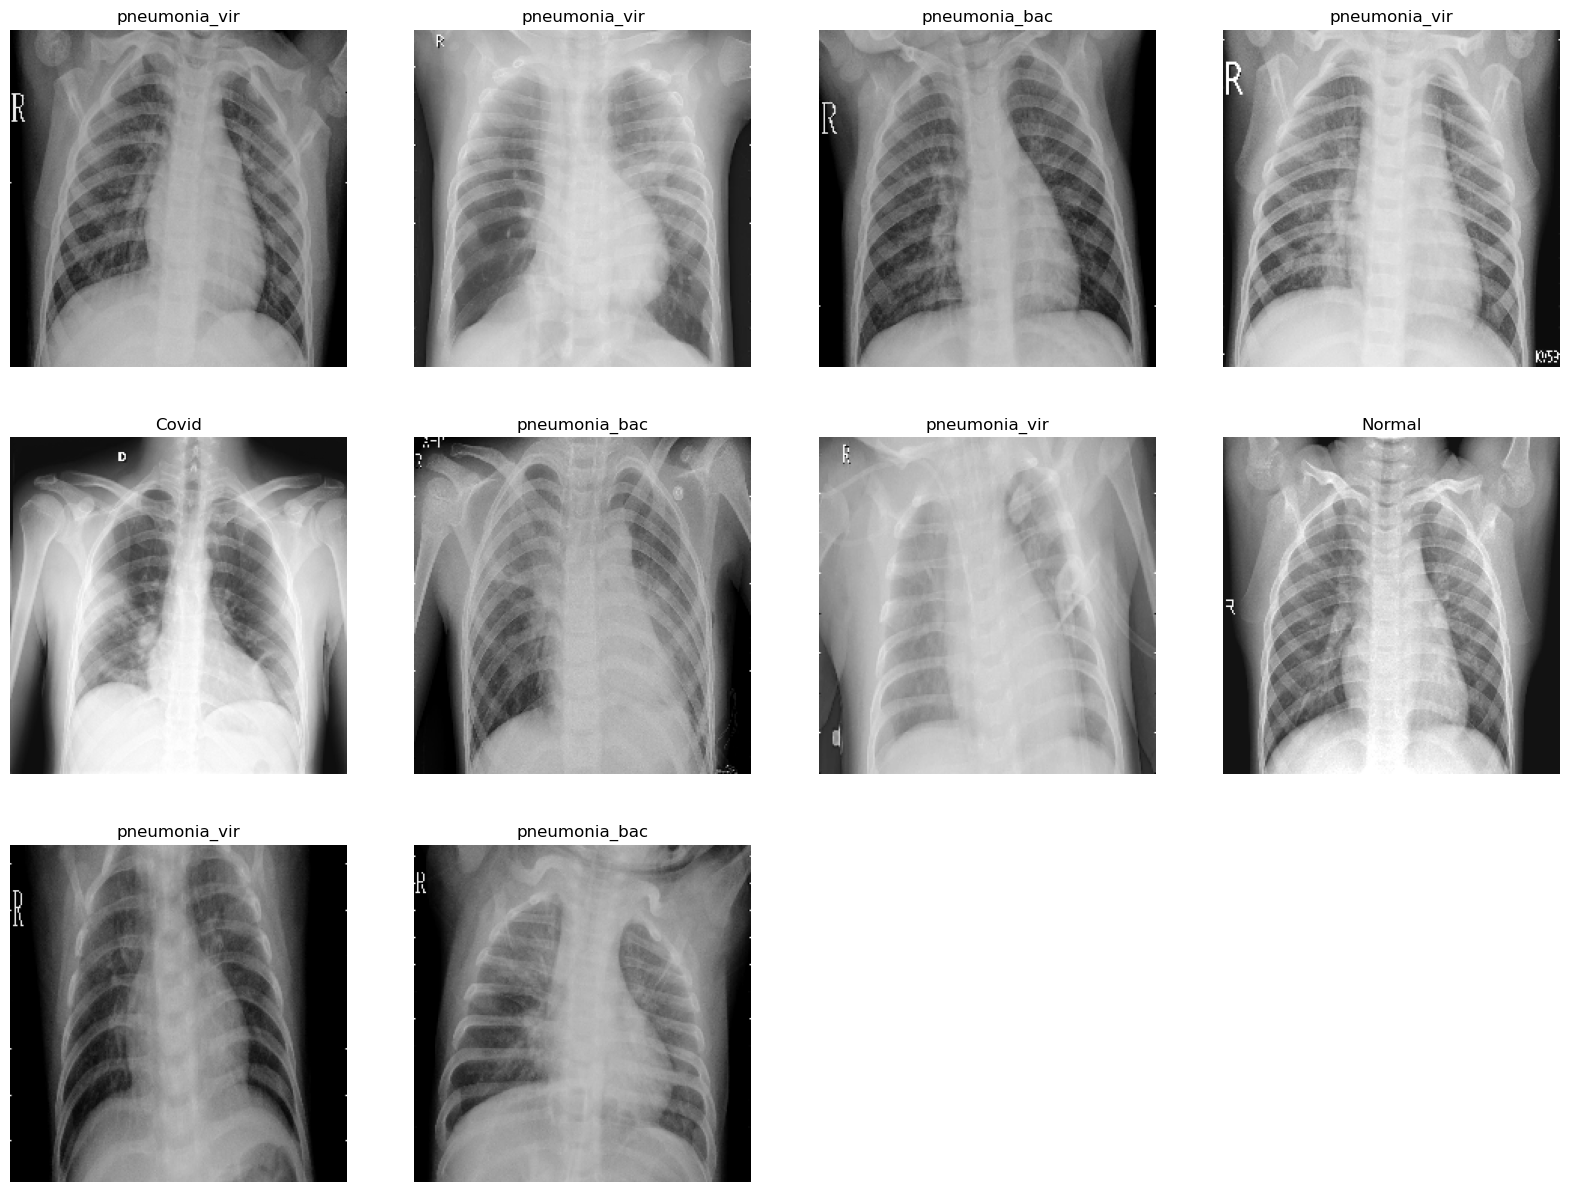

In [29]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]
    
    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Covid" if np.argwhere(img_label[i] == 1).item()== 0 else (
            "Normal" if np.argwhere(img_label[i] == 1).item()== 1 else (
            "pneumonia_bac" if np.argwhere(img_label[i] == 1).item()== 2 else "pneumonia_vir" )))
        plt.axis("off")

image_plot(train_batches,10)

#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [31]:
VGG16= tf.keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=(224, 224, 3))
model = tf.keras.models.Sequential([
  VGG16,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', name='feature_dense'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='softmax')
  
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 feature_dense (Dense)       (None, 128)               3211392   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 17,926,596
Non-trainable params: 0
_________________________________________________________________


In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

#### [5 points] Train Model

In [35]:
#FIT MODEL
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_all_best.h5', monitor='val_accuracy', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]
history = model.fit(train_batches,  epochs=NUM_EPOCHS, validation_data=valid_batches,shuffle=False, 
        verbose=True, callbacks=callbacks_list) # Use correct args here.

Epoch 1/40
22/22 [==============================] - ETA: 0s - loss: 1.1942 - accuracy: 0.4491 
Epoch 1: accuracy improved from -inf to 0.44907, saving model to model/vgg16_all_best.h5
22/22 [==============================] - 306s 14s/step - loss: 1.1942 - accuracy: 0.4491 - val_loss: 0.8814 - val_accuracy: 0.6852
Epoch 2/40
22/22 [==============================] - ETA: 0s - loss: 0.7223 - accuracy: 0.7361 
Epoch 2: accuracy improved from 0.44907 to 0.73611, saving model to model/vgg16_all_best.h5
22/22 [==============================] - 324s 15s/step - loss: 0.7223 - accuracy: 0.7361 - val_loss: 0.5364 - val_accuracy: 0.8333
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8472 
Epoch 3: accuracy improved from 0.73611 to 0.84722, saving model to model/vgg16_all_best.h5
22/22 [==============================] - 599s 28s/step - loss: 0.4252 - accuracy: 0.8472 - val_loss: 0.4486 - val_accuracy: 0.8148
Epoch 4/40
22/22 [==============================]

#### [5 points] Plot Accuracy and Loss During Training

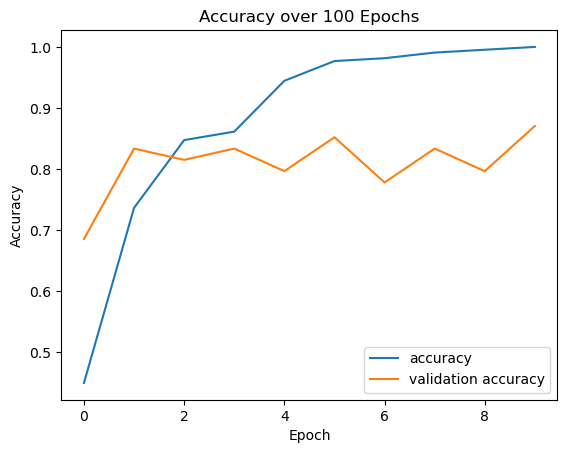

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over 100 Epochs')
plt.legend(loc='lower right')


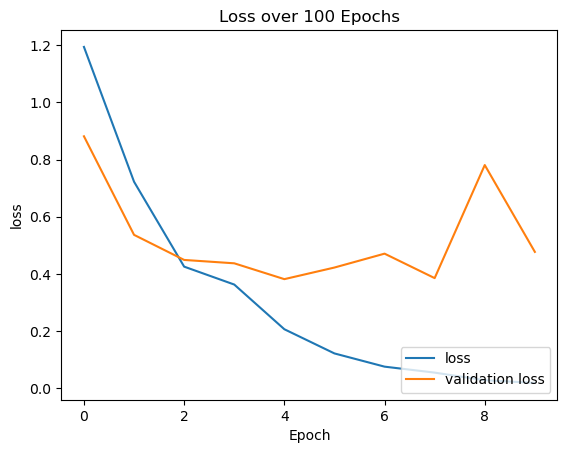

In [37]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss over 100 Epochs')
plt.legend(loc='lower right')

#### Testing Model

In [38]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36


/var/folders/2w/r4bgqlv108jffbghr56v0x780000gn/T/ipykernel_44816/463003407.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),


36/36 [==============================] - 14s 370ms/step - loss: 0.5789 - accuracy: 0.6944
Test loss: 0.5788952112197876
Test accuracy: 0.6944444179534912


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [45]:
from sklearn.manifold import TSNE
from tensorflow.keras import models,layers,optimizers
intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('feature_dense').output)

tsne_eval_generator = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")



labels = []
tsne_inputs = []
for i in range(len(tsne_eval_generator)):
    feature, label = tsne_eval_generator[i]
    y = intermediate_layer_model(feature)
    if np.argwhere(label[0] == 1).item()== 0:
        labels.append("Covid")
    elif np.argwhere(label[0] == 1).item()== 1:
        labels.append("Normal")
    elif np.argwhere(label[0] == 1).item()== 2:
        labels.append("pneumonia_bac")
    else:
        labels.append("pneumonia_vir")
    tsne_inputs.append(y[0])
tsne_inputs = np.array(tsne_inputs)


Found 270 images belonging to 4 classes.


In [48]:
tsne_inputs.shape

(270, 128)

In [49]:
tsne_result = TSNE(n_components=2, method='exact').fit_transform(tsne_inputs)
tsne_result.shape

(270, 2)

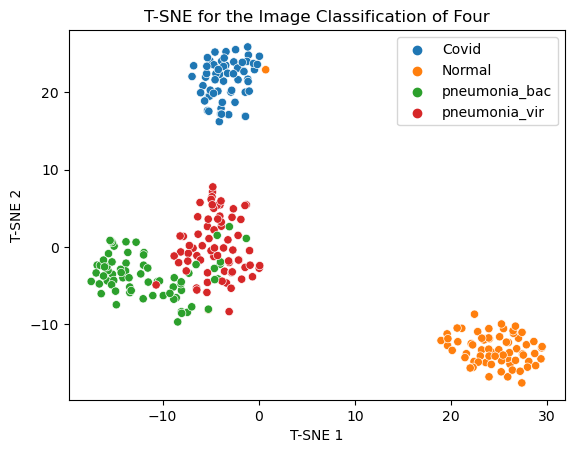

In [50]:
tsne_result_df = pd.DataFrame({'T-SNE 1': tsne_result[:,0], 'T-SNE 2': tsne_result[:,1],
                               'label': labels})
sns.scatterplot(x='T-SNE 1', y='T-SNE 2', hue='label', data=tsne_result_df)
plt.title("T-SNE for the Image Classification of Four")
plt.legend()
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->